In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import argparse
import logging
import shutil
import re
from PIL import Image
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
from torchvision.datasets import VisionDataset
from torchvision import transforms
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
%matplotlib inline

DATA_DIR = '/data/amiratag/prostate'
MEM_DIR = '/home/amiratag/Projects/Prostate'

DATA_DIR = "/export/medical_ai/kaggle_panda"

In [2]:
parser = argparse.ArgumentParser(
    description='PyTorch TRADES Adversarial Training')


parser.add_argument('--model_dir', default='./models/random_flips',
                    help='Directory of model for saving checkpoint')
parser.add_argument('--overwrite', action='store_true', default=False,
                    help='Cancels the run if an appropriate checkpoint is found')

# Logging and checkpointing
parser.add_argument('--log_interval', type=int, default=500,
                    help='Number of batches between logging of training status')
parser.add_argument('--save_freq', default=1, type=int,
                    help='Checkpoint save frequency (in epochs)')

# Generic training configs
parser.add_argument('--seed', type=int, default=1,
                    help='Random seed. '
                         'Note: fixing the random seed does not give complete '
                         'reproducibility. See '
                         'https://pytorch.org/docs/stable/notes/randomness.html')
parser.add_argument('--batch_size', type=int, default=192, metavar='N',
                    help='Input batch size for training (default: 128)')
parser.add_argument('--test_batch_size', type=int, default=128, metavar='N',
                    help='Input batch size for testing (default: 128)')
parser.add_argument('--epochs', type=int, default=100, metavar='N',
                    help='Number of epochs to train. '
                         'Note: we arbitrarily define an epoch as a pass '
                         'through 50K datapoints. This is convenient for '
                         'comparison with standard CIFAR-10 training '
                         'configurations.')
parser.add_argument('--eval_freq', default=5, type=int,
                    help='Eval frequency (in epochs)')
parser.add_argument('--weight_decay', '--wd', default=5e-4, type=float)
parser.add_argument('--lr', type=float, default=0.05, metavar='LR',
                    help='Learning rate')
parser.add_argument('--lr_schedule', type=str, default='cosine',
                    choices=('trades', 'trades_fixed', 'cosine', 'wrn'),
                    help='Learning rate schedule')
parser.add_argument('--momentum', type=float, default=0.9, metavar='M',
                    help='SGD momentum')
parser.add_argument('--nesterov', action='store_true', default=True,
                    help='Use extragrdient steps')
parser.add_argument('--balanced', action='store_true', default=True,
                    help='Use balanced dataset')

args = parser.parse_args('')

In [3]:
def balanced_dataset(X, y, max_size=None, min_size=None):
    
    np.random.seed(0)
    counts = np.bincount(y)
    labels, counts = np.unique(y, return_counts=True)
    minority = np.min(counts)
    if min_size is not None:
        minority = max(minority, min_size // len(labels))
    idxs = []
    for label in labels:
        label_idxs = np.where(y == label)[0]
        if len(label_idxs) >= minority:
            idxs.extend(np.random.choice(label_idxs, minority, replace=False))
        else:
            idxs.extend(np.random.choice(label_idxs, minority, replace=True))
    idxs = np.random.permutation(idxs)
    if max_size:
        idxs = idxs[:max_size]
    return X[idxs], y[idxs]

def adjust_learning_rate(optimizer, epoch):
    """decrease the learning rate"""
    lr = args.lr
    schedule = args.lr_schedule
    # schedule from TRADES repo (different from paper due to bug there)
    if schedule == 'trades':
        if epoch >= 0.75 * args.epochs:
            lr = args.lr * 0.1
    # schedule as in TRADES paper
    elif schedule == 'trades_fixed':
        if epoch >= 0.75 * args.epochs:
            lr = args.lr * 0.1
        if epoch >= 0.9 * args.epochs:
            lr = args.lr * 0.01
        if epoch >= args.epochs:
            lr = args.lr * 0.001
    # cosine schedule
    elif schedule == 'cosine':
        lr = args.lr * 0.5 * (1 + np.cos((epoch - 1) / args.epochs * np.pi))
    # schedule as in WRN paper
    elif schedule == 'wrn':
        if epoch >= 0.3 * args.epochs:
            lr = args.lr * 0.2
        if epoch >= 0.6 * args.epochs:
            lr = args.lr * 0.2 * 0.2
        if epoch >= 0.8 * args.epochs:
            lr = args.lr * 0.2 * 0.2 * 0.2
    else:
        raise ValueError('Unkown LR schedule %s' % schedule)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

In [4]:
class CustomDataset(VisionDataset):
    
    def __init__(self, X, y, train=True, transform=None, target_transform=None, download=None):
        
        super(CustomDataset, self).__init__('', transform=transform,
                                      target_transform=target_transform)
        self.train = train
        self.X = X
        self.y = y
        assert len(self.X) == len(self.y)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        
        img, target = self.X[index], self.y[index]
        img = np.array(Image.open(img))
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target
    
    def extra_repr(self):
        return "Split: {}".format("Train" if self.train is True else "Test")
    
class DenseNet(torch.nn.Module):
    
    def __init__(self, num_classes, pretrained=True):
        super(DenseNet, self).__init__()
        self.feature_extractor = models.densenet121(pretrained=pretrained)
        self.final = torch.nn.Linear(1000, num_classes)
    
    def forward(self, x):
        x = self.feature_extractor(x)
        return self.final(x)

In [5]:
if args.overwrite:
    shutil.rmtree(args.model_dir)
if not os.path.exists(args.model_dir):
    os.makedirs(args.model_dir)
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(message)s",
    handlers=[
        logging.FileHandler(os.path.join(args.model_dir, 'training.log')),
        logging.StreamHandler()
    ])
logger = logging.getLogger()

logging.info('Robust self-training')
logging.info('Args: %s', args)

2021-03-07 21:28:51,355 | Robust self-training
2021-03-07 21:28:51,357 | Args: Namespace(balanced=True, batch_size=192, epochs=100, eval_freq=5, log_interval=500, lr=0.05, lr_schedule='cosine', model_dir='./models/random_flips', momentum=0.9, nesterov=True, overwrite=False, save_freq=1, seed=1, test_batch_size=128, weight_decay=0.0005)


In [6]:
args.balanced = True

In [7]:
classes = np.arange(6).astype(str)
paths, labels = [], []
for cls in classes:
    new_paths = os.listdir(os.path.join(DATA_DIR, 'patches', cls))
    paths.extend([os.path.join(DATA_DIR, 'patches', cls, i) for i in new_paths])
    labels.extend([int(cls)] * len(new_paths))
paths, labels = np.array(paths), np.array(labels)
X_train, X_val, y_train, y_val = train_test_split(paths, labels, test_size=0.1, stratify=labels, random_state=0)
if args.balanced:
    X_train, y_train = balanced_dataset(X_train, y_train, min_size=3000000)
    X_val, y_val = balanced_dataset(X_val, y_val, min_size=300000)

In [8]:
cudnn.benchmark = True
use_cuda = torch.cuda.is_available()
torch.manual_seed(args.seed)
device = torch.device('cuda') if use_cuda else 'cpu'

In [9]:
train_transforms = transforms.Compose(
    [transforms.ToPILImage(), 
     transforms.RandomHorizontalFlip(), 
     transforms.RandomVerticalFlip(), 
     transforms.ToTensor()])
test_transofrms = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor()])
dataset = CustomDataset(X_train, y_train, train=True, transform=train_transforms)
val_dataset = CustomDataset(X_val, y_val, train=False, transform=train_transforms)
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True, **kwargs)
val_loader = DataLoader(val_dataset, batch_size=args.test_batch_size, shuffle=False, **kwargs)

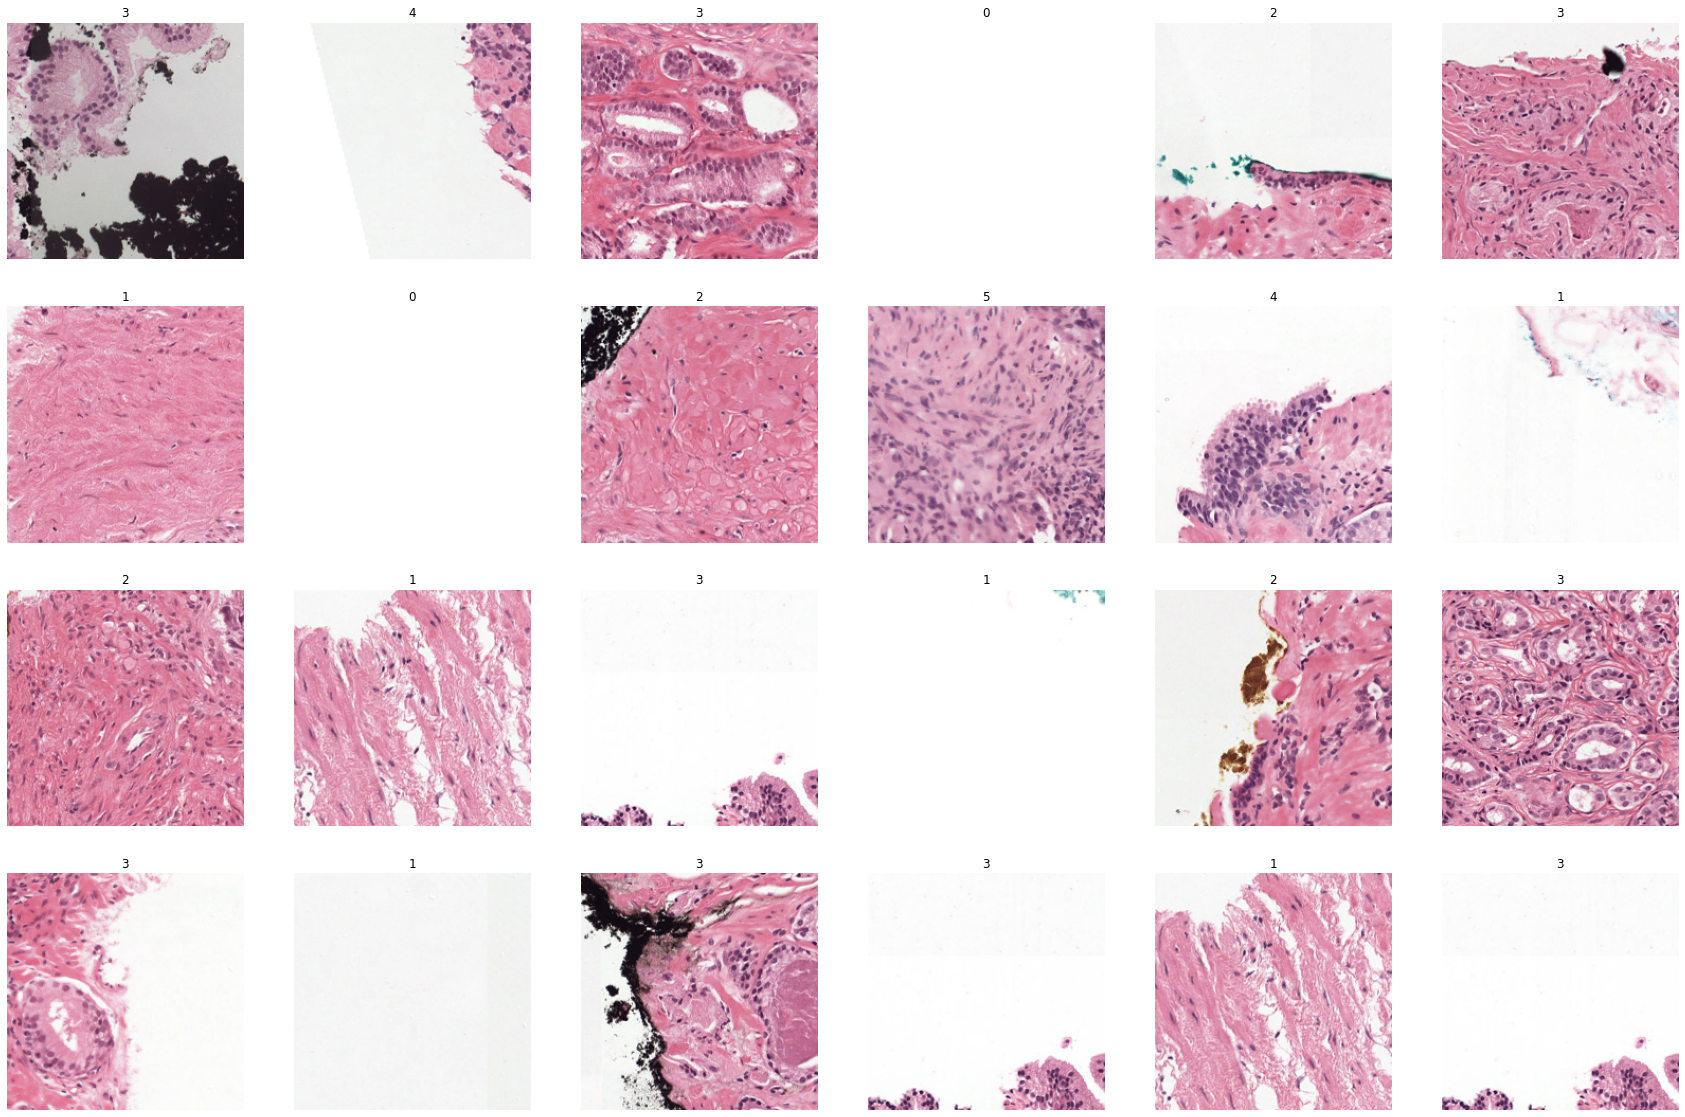

In [10]:
fig = plt.figure(figsize=(30, 20))
for x, y in train_loader:
    break
x = x.detach().numpy().transpose((0, 2, 3, 1))
y = y.detach().numpy()
for i in range(24):
    plt.subplot(4, 6, i+1)
    idx = np.random.choice(len(x))
    plt.imshow(x[idx])
    plt.title(y[idx])
    plt.axis('off')

In [20]:
num_classes = 6
model = DenseNet(num_classes)
if use_cuda:
    model = torch.nn.DataParallel(model).cuda()
optimizer = optim.SGD(model.parameters(), lr=args.lr,
                      momentum=args.momentum,
                      weight_decay=args.weight_decay,
                      nesterov=args.nesterov)
init_epoch = 0
train_df = pd.DataFrame()
eval_df = pd.DataFrame()
## Load existing checkpoints and logs
checkpoints = [i for i in os.listdir(args.model_dir) if '.pt' in i]
checkpoints_epoch_num = [int(re.search('epoch(\d+)', c).group(1)) for c in checkpoints]
if len(checkpoints_epoch_num):
    init_epoch = np.max(checkpoints_epoch_num)
    checkpoint = torch.load(os.path.join(args.model_dir, 'checkpoint-epoch{}.pt'.format(init_epoch)))
    state_dict = checkpoint.get('state_dict', checkpoint)
    model.load_state_dict(state_dict)
    opt_checkpoint = torch.load(os.path.join(args.model_dir, 'opt-checkpoint_epoch{}.tar'.format(init_epoch)))
    optimizer.load_state_dict(opt_checkpoint)
    logger.info('Loading checkpoint from epoch #{}'.format(init_epoch))
    train_df = pd.read_csv(os.path.join(args.model_dir, 'stats_train.csv'), index_col=0)
    train_df.drop(train_df.index[np.arange(init_epoch, len(eval_df))], inplace=True)
    eval_df = pd.read_csv(os.path.join(args.model_dir, 'stats_eval.csv'), index_col=0)
    eval_df.drop(eval_df.index[np.arange(init_epoch, len(eval_df))], inplace=True)

2021-03-08 17:18:32,312 | Loading checkpoint from epoch #33


In [21]:
epoch_size = 2000
for epoch in range(init_epoch+1, args.epochs + 1):
    
    lr = adjust_learning_rate(optimizer, epoch)
    logger.info('Setting learning rate to %g' % lr)
    train_data = train(args, model, device, train_loader, optimizer, epoch, epoch_size=epoch_size)
    train_df = train_df.append(pd.DataFrame(train_data), ignore_index=True)

    # evaluation on natural examples
    logging.info(120 * '=')
    if epoch % args.eval_freq == 0 or epoch == args.epochs:
        eval_data = {'epoch': int(epoch)}
        eval_data.update(
            eval(args, model, device, val_loader, num_eval_batches=300))
        eval_df = eval_df.append(pd.Series(eval_data), ignore_index=True)
        logging.info(120 * '=')

    # save stats
    train_df.to_csv(os.path.join(args.model_dir, 'stats_train.csv'))
    eval_df.to_csv(os.path.join(args.model_dir, 'stats_eval.csv'))
    
    if epoch % args.save_freq == 0 or epoch == args.epochs:
        torch.save(dict(num_classes=num_classes,
                        state_dict=model.state_dict()),
                   os.path.join(args.model_dir,
                                'checkpoint-epoch{}.pt'.format(epoch)))
        torch.save(optimizer.state_dict(),
                   os.path.join(args.model_dir,
                                'opt-checkpoint_epoch{}.tar'.format(epoch)))

2021-03-08 17:18:32,377 | Setting learning rate to 0.037726
2021-03-08 17:18:33,951 | Train Epoch: 34 [0/384000 (0%)]	Loss: 0.516165
2021-03-08 17:24:49,650 | Train Epoch: 34 [96000/384000 (25%)]	Loss: 0.483550
2021-03-08 17:31:01,733 | Train Epoch: 34 [192000/384000 (50%)]	Loss: 0.412286
2021-03-08 17:37:14,364 | Train Epoch: 34 [288000/384000 (75%)]	Loss: 0.441279
2021-03-08 17:43:28,934 | ========================================================================================================================
2021-03-08 17:43:29,611 | Setting learning rate to 0.0370438
2021-03-08 17:43:31,136 | Train Epoch: 35 [0/384000 (0%)]	Loss: 0.518105
2021-03-08 17:49:42,982 | Train Epoch: 35 [96000/384000 (25%)]	Loss: 0.461260
2021-03-08 17:55:56,434 | Train Epoch: 35 [192000/384000 (50%)]	Loss: 0.547893
2021-03-08 18:02:09,632 | Train Epoch: 35 [288000/384000 (75%)]	Loss: 0.574959
2021-03-08 18:08:21,830 | ========================================================================================

2021-03-08 23:25:31,505 | Train Epoch: 48 [192000/384000 (50%)]	Loss: 0.413817
2021-03-08 23:31:40,677 | Train Epoch: 48 [288000/384000 (75%)]	Loss: 0.581126
2021-03-08 23:37:49,695 | ========================================================================================================================
2021-03-08 23:37:50,458 | Setting learning rate to 0.0265698
2021-03-08 23:37:51,990 | Train Epoch: 49 [0/384000 (0%)]	Loss: 0.519709
2021-03-08 23:44:04,548 | Train Epoch: 49 [96000/384000 (25%)]	Loss: 0.458146
2021-03-08 23:50:15,624 | Train Epoch: 49 [192000/384000 (50%)]	Loss: 0.413916
2021-03-08 23:56:24,863 | Train Epoch: 49 [288000/384000 (75%)]	Loss: 0.486128
2021-03-09 00:02:33,936 | ========================================================================================================================
2021-03-09 00:02:34,705 | Setting learning rate to 0.0257853
2021-03-09 00:02:36,473 | Train Epoch: 50 [0/384000 (0%)]	Loss: 0.480599
2021-03-09 00:08:47,048 | Train Epoch: 50 [9

2021-03-09 05:31:57,346 | Setting learning rate to 0.0157969
2021-03-09 05:31:58,903 | Train Epoch: 63 [0/384000 (0%)]	Loss: 0.547695
2021-03-09 05:38:04,254 | Train Epoch: 63 [96000/384000 (25%)]	Loss: 0.426509
2021-03-09 05:44:08,551 | Train Epoch: 63 [192000/384000 (50%)]	Loss: 0.435653
2021-03-09 05:50:22,766 | Train Epoch: 63 [288000/384000 (75%)]	Loss: 0.383699
2021-03-09 05:56:31,388 | ========================================================================================================================
2021-03-09 05:56:32,188 | Setting learning rate to 0.0150713
2021-03-09 05:56:33,698 | Train Epoch: 64 [0/384000 (0%)]	Loss: 0.444658
2021-03-09 06:02:38,849 | Train Epoch: 64 [96000/384000 (25%)]	Loss: 0.499807
2021-03-09 06:08:42,692 | Train Epoch: 64 [192000/384000 (50%)]	Loss: 0.506783
2021-03-09 06:14:45,254 | Train Epoch: 64 [288000/384000 (75%)]	Loss: 0.444212
2021-03-09 06:20:48,272 | =======================================================================================

2021-03-09 11:34:03,661 | Train Epoch: 77 [192000/384000 (50%)]	Loss: 0.475295
2021-03-09 11:40:10,403 | Train Epoch: 77 [288000/384000 (75%)]	Loss: 0.430302
2021-03-09 11:46:20,134 | ========================================================================================================================
2021-03-09 11:46:21,019 | Setting learning rate to 0.00624722
2021-03-09 11:46:22,526 | Train Epoch: 78 [0/384000 (0%)]	Loss: 0.378604
2021-03-09 11:52:29,319 | Train Epoch: 78 [96000/384000 (25%)]	Loss: 0.443508
2021-03-09 11:58:36,550 | Train Epoch: 78 [192000/384000 (50%)]	Loss: 0.333647
2021-03-09 12:04:44,843 | Train Epoch: 78 [288000/384000 (75%)]	Loss: 0.367694
2021-03-09 12:10:53,702 | ========================================================================================================================
2021-03-09 12:10:54,573 | Setting learning rate to 0.00573717
2021-03-09 12:10:56,099 | Train Epoch: 79 [0/384000 (0%)]	Loss: 0.457342
2021-03-09 12:17:05,502 | Train Epoch: 79 

2021-03-09 17:38:02,000 | Setting learning rate to 0.000992658
2021-03-09 17:38:03,486 | Train Epoch: 92 [0/384000 (0%)]	Loss: 0.325541
2021-03-09 17:44:13,092 | Train Epoch: 92 [96000/384000 (25%)]	Loss: 0.278812
2021-03-09 17:50:19,847 | Train Epoch: 92 [192000/384000 (50%)]	Loss: 0.288196
2021-03-09 17:56:25,626 | Train Epoch: 92 [288000/384000 (75%)]	Loss: 0.280509
2021-03-09 18:02:32,072 | ========================================================================================================================
2021-03-09 18:02:32,998 | Setting learning rate to 0.000785421
2021-03-09 18:02:34,501 | Train Epoch: 93 [0/384000 (0%)]	Loss: 0.402270
2021-03-09 18:08:39,242 | Train Epoch: 93 [96000/384000 (25%)]	Loss: 0.290066
2021-03-09 18:14:45,929 | Train Epoch: 93 [192000/384000 (50%)]	Loss: 0.305656
2021-03-09 18:20:52,130 | Train Epoch: 93 [288000/384000 (75%)]	Loss: 0.297708
2021-03-09 18:26:58,153 | ===================================================================================

KeyboardInterrupt: 

In [22]:
labels, outputs = eval(args, model, device, val_loader, num_eval_batches=100, confusion=True)
labels = torch.cat(labels).detach().cpu().numpy()
outputs = torch.cat(outputs).detach().cpu().numpy()

101it [00:47,  2.15it/s]
2021-03-09 20:53:48,427 | Clean loss: 0.3964, Clean accuracy: 11146/13056 (85.37%), 


In [23]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels, outputs)

In [24]:
set(labels.reshape(-1))

{0, 1, 2, 3, 4, 5}

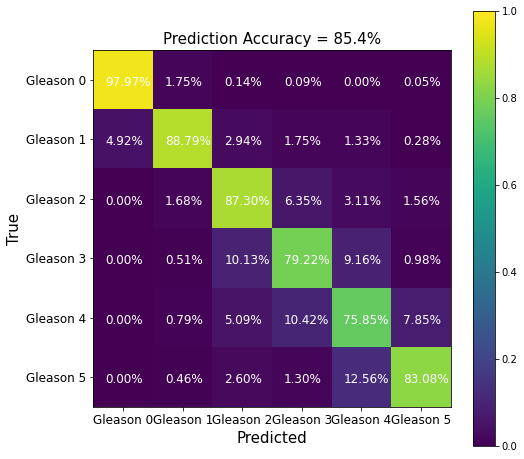

In [25]:
from sklearn.metrics import confusion_matrix
fig = plt.figure(figsize=(8, 8))
cm = confusion_matrix(labels, outputs)
normalized_cm = cm/np.sum(cm, -1, keepdims=True)
plt.imshow(normalized_cm, vmin=0., vmax=1)
plt.colorbar()
plt.xticks(np.arange(6), ['Gleason {}'.format(i) for i in range(6)], fontsize=12)
plt.yticks(np.arange(6), ['Gleason {}'.format(i) for i in range(6)], fontsize=12)
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('True', fontsize=15)
plt.title('Prediction Accuracy = {0:.1f}%'.format(100 * np.mean(labels == outputs)), fontsize=15)
for i in range(6):
    for j in range(6):
        plt.annotate('{0:.2f}%'.format(100 * normalized_cm[i, j]), (j-0.3, i+0.1), color='white', fontsize=12)

In [89]:
for x, y in train_loader:
    break

In [13]:
def eval(args, model, device, loader, num_eval_batches=None, confusion=False):
    loss = 0
    total = 0
    correct = 0
    model.eval()
    labels, outputs = [], []
    with torch.no_grad():
        for batch_idx, (data, target) in tqdm(enumerate(loader)):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            labels.append(target.view_as(pred))
            outputs.append(pred)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += len(data)
            if num_eval_batches is not None and batch_idx > num_eval_batches:
                break
    loss /= total
    accuracy = correct / total

    eval_data = dict(loss=loss, accuracy=accuracy)
    logging.info(
        'Clean loss: {:.4f}, '
        'Clean accuracy: {}/{} ({:.2f}%), '.format(
            loss,
            correct, total, 100.0 * accuracy))
    if confusion:
        return labels, outputs
    else:
        return eval_data

In [14]:
def train(args, model, device, train_loader, optimizer, epoch, epoch_size=None):
    
    if epoch_size is None:
        epoch_size = len(train_loader)
    model.train()
    train_metrics = []
    counter = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        logits = model(data)
        loss = F.cross_entropy(logits, target)
        loss.backward()
        optimizer.step()
        
        train_metrics.append(dict(
            epoch=epoch,
            loss=loss.item()))
        # print progress
        if batch_idx % args.log_interval == 0:
            logging.info(
                'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), epoch_size * args.batch_size,
                           100. * batch_idx / epoch_size, loss.item()))
        counter += 1
        if counter >= epoch_size:
            break
    return train_metrics